# **Evaluate models and algorithms**

# 0. Introduction

Dans ce notebook, on passe en revue l'ensemble des modèles de machine learning adaptés à la classification. On détermine le meilleur choix de modèle en fonction de sa performance et de la métrique la plus adaptée à notre problème que l'on cherche à optimiser.

# 1. Imports

In [19]:
import src.settings.base as stg
from src.infrastructure.dataframecreation import DataFrameBuilder
from src.domain.featureselection import FeatureSelector

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [20]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

# 2. Dataframe et partition du dataset

In [21]:
df = FeatureSelector().women_decisions
X = FeatureSelector().women_decisions_features
Y = FeatureSelector().women_decisions_target

In [22]:
test_size = stg.TEST_SIZE
seed = stg.SEED
num_folds = stg.NUM_FOLDS
scoring = 'accuracy'
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# 3. Evalutation des modèles de classification

## 3.1 Première évaluation 

In [23]:
# spot-check basic Classification algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('Gaussian NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('MLPC', MLPClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('ETC', ExtraTreesClassifier()))

In [24]:
names = []
kfold_results = []
for name, model in models:
    names.append(name)
    
    ## k-fold analysis
    kfold = KFold(n_splits=num_folds)
    
    ## cv results
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    msg = f'{name}: {round(cv_results.mean(), 5)} ({round(cv_results.std(), 5)})'
    print(msg)

LR: 0.74501 (0.01502)
LDA: 0.74393 (0.01634)
KNN: 0.72765 (0.03403)
CART: 0.68134 (0.0283)
Gaussian NB: 0.69726 (0.02678)
SVC: 0.74321 (0.01819)
MLPC: 0.74501 (0.01935)
ABC: 0.74139 (0.022)
GBC: 0.75732 (0.02326)
RFC: 0.72005 (0.03004)
ETC: 0.70703 (0.02845)


<function matplotlib.pyplot.show(close=None, block=None)>

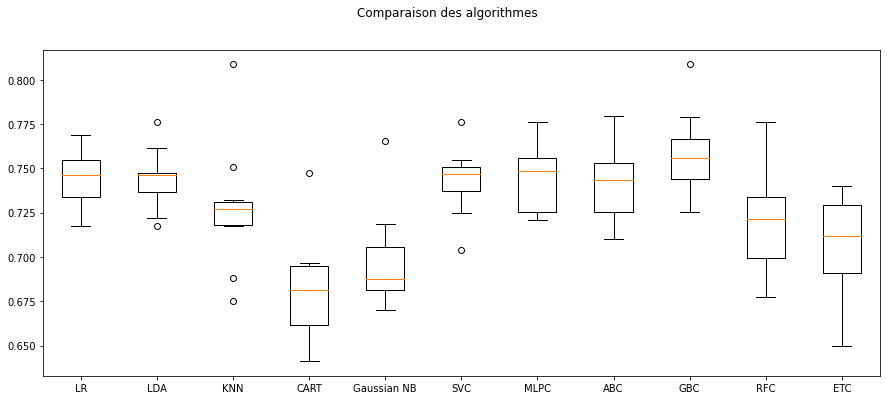

In [25]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,6)
plt.show

L'**accuracy** de l'ensemble des résultats est correcte: entre 70 et 75% pour la quasi-totalité des modèles. On garde un modèle ayant obtenu le meilleur résultat (*GradientBoostingClassifier*, **75%**) et on observe le résultat sur l'échantillon de test.

In [26]:
# on prépare le modèle
gbc = GradientBoostingClassifier()
gbc.fit(X_train, Y_train)

GradientBoostingClassifier()

In [27]:
# on estime l'accuracy sur l'échantillon de test
predictions = gbc.predict(X_test)
print(accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.75
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       432
           1       0.69      0.60      0.64       260

    accuracy                           0.75       692
   macro avg       0.74      0.72      0.73       692
weighted avg       0.75      0.75      0.75       692



Et on fournit la matrice de confusion:

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

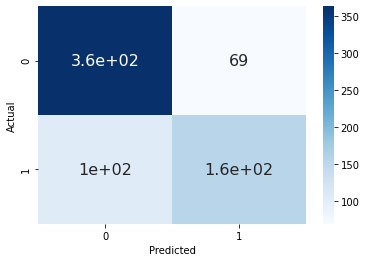

In [28]:
df_mc = pd.DataFrame(confusion_matrix(Y_test, predictions), 
                     columns=np.unique(Y_test),
                     index=np.unique(Y_test))
df_mc.index.name = 'Actual'
df_mc.columns.name = 'Predicted'
sns.heatmap(df_mc, cmap="Blues", annot=True, annot_kws={'size': 16})

Nous avons:   **692** décisions.

- **361** décisions négatives prévues et qui se sont bien révélées négatives.
- **101** décisions négatives prévues et qui se sont en fait révélées positives.
- **69** décisions positives prévues et qui se sont hélas révélées négatives.
- **161** décisions positives prévues et qui se sont bien révélées positives.

On cherche un modéle qui va **prévoir le mieux possible des décisions positives et qui se révèlent effectivement positive**. Mais aussi...

- Un modèle qui s'efforce de minimiser des prévisions négatives alors que l'issue est en fait positive (**recall**) ?

- Un modèle qui s'efforce de minimiser des prévisions positives alors que l'issue est en fait négative (**precision**) ?

Bien que ce choix soit subjectif, nous pensons que les participants vont préférer être orientés vers un parti "sûr", afin d'éviter de manquer l'éventuelle "âme soeur" et de concentrer leur énergie en ce sens. 

On choisit donc comme métrique le **recall** qu'il convient de chercher à **maximiser** en **minimisant les faux négatifs**.

## 3.2 Deuxième évaluation et tuning du modèle avec la métrique adaptée

In [11]:
scoring = 'recall'

In [12]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('Gaussian NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('MLPC', MLPClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('ETC', ExtraTreesClassifier()))

In [14]:
names = []
kfold_results = []
for name, model in models:
    names.append(name)
    
    ## k-fold analysis
    kfold = KFold(n_splits=num_folds)
    
    ## cv results
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    msg = f'{name}: {round(cv_results.mean(), 5)} ({round(cv_results.std(), 5)})'
    print(msg)

LR: 0.58176 (0.04371)
LDA: 0.58097 (0.04445)
KNN: 0.58242 (0.06033)
CART: 0.57088 (0.0693)
Gaussian NB: 0.73905 (0.04555)
SVC: 0.54947 (0.04274)
MLPC: 0.59265 (0.08721)
ABC: 0.59868 (0.05346)
GBC: 0.59867 (0.04847)
RFC: 0.59219 (0.06002)
ETC: 0.55762 (0.05796)


On voit que le Gaussian NB élève de manière significative le niveau du recall. On garde ce modèle. 

<function matplotlib.pyplot.show(close=None, block=None)>

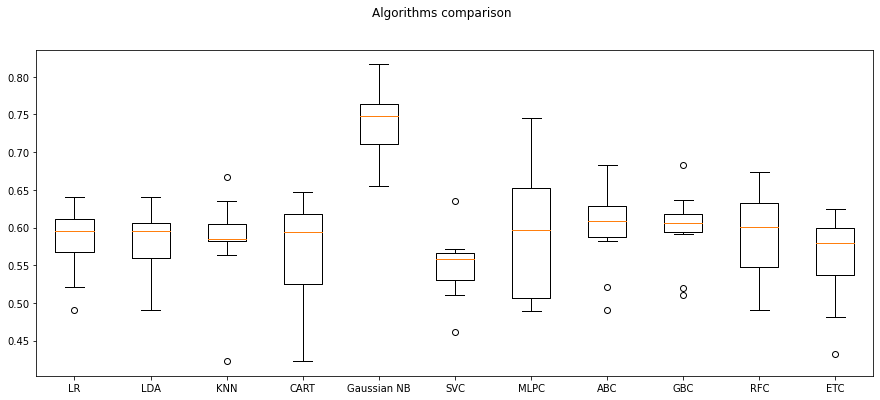

In [15]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,6)
plt.show

In [16]:
# on prépare le modèle
gnb = GaussianNB()
gnb.fit(X_train, Y_train)

GaussianNB()

In [17]:
# on estime le recall sur l'échantillon de test
predictions = gnb.predict(X_test)
print(recall_score(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.7653846153846153
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       432
           1       0.60      0.77      0.68       260

    accuracy                           0.72       692
   macro avg       0.72      0.73      0.72       692
weighted avg       0.75      0.72      0.73       692



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

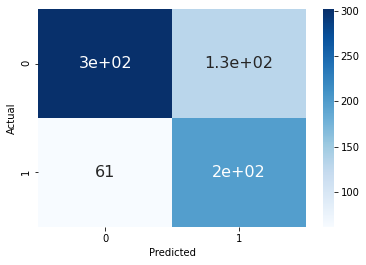

In [18]:
df_mc = pd.DataFrame(confusion_matrix(Y_test, predictions), 
                     columns=np.unique(Y_test),
                     index=np.unique(Y_test))
df_mc.index.name = 'Actual'
df_mc.columns.name = 'Predicted'
sns.heatmap(df_mc, cmap="Blues", annot=True, annot_kws={'size': 16})

Nous avons:   **692** décisions.

- **301** décisions négatives prévues et qui se sont bien révélées négatives.
- **61** décisions négatives prévues et qui se sont en fait révélées positives.
- **130** décisions positives prévues et qui se sont hélas révélées négatives.
- **200** décisions positives prévues et qui se sont bien révélées positives.

On voit que refaire le cheminement avec l'ensemble des modèles s'est révélé payant:

- Le nombre de faux négatifs est passé de 101 à 61.
- Le recall est passé 60% à 77%, soit plus 17 points.
- Le modèle ne semble pas soumis à l'**underfitting** avec un score de 77% au test, ce qui est convenable.
- Le modèle ne semble pas soumis à l'**overfitting** avec une score en petite hausse de 3% au test (74% à l'entraînement).

Le modèle Gaussian Naive Bayes n'est pas hyperparamètrable. On regardera si le tuning des hyperparamètres des autres modèles apporte des gains significatifs de performance, ce qui est peu probable.

In [18]:
# sauvegarde du modèle avec Pickle
from pickle import dump
from pickle import load

# sauver le modèle sur disque
filename = 'finalized_speed_dating_model.sav'
dump(gnb, open(filename, 'wb'))

In [19]:
# charger le modèle depuis le disque
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on test set
predictions = loaded_model.predict(X_test)
result = recall_score(Y_test, predictions)
print(result)

0.7653846153846153


## 3.3 Test avec un modèle Keras de deep learning

In [19]:
from src.application.Keras_NN_model import Keras_classification

In [24]:
ker = Keras_classification(X, Y, X_train, X_test, Y_train, Y_test).Keras_classifier()
ker

Epoch 1/10
277/277 [==============================] - 0s 449us/step - loss: 0.6327 - accuracy: 0.6286
Epoch 2/10
277/277 [==============================] - 0s 441us/step - loss: 0.6038 - accuracy: 0.6282
Epoch 3/10
277/277 [==============================] - 0s 468us/step - loss: 0.5948 - accuracy: 0.6282
Epoch 4/10
277/277 [==============================] - 0s 446us/step - loss: 0.5891 - accuracy: 0.6503
Epoch 5/10
277/277 [==============================] - 0s 435us/step - loss: 0.5831 - accuracy: 0.7005
Epoch 6/10
277/277 [==============================] - 0s 446us/step - loss: 0.5808 - accuracy: 0.6991
Epoch 7/10
277/277 [==============================] - 0s 436us/step - loss: 0.5789 - accuracy: 0.7085
Epoch 8/10
277/277 [==============================] - 0s 443us/step - loss: 0.5753 - accuracy: 0.7060
Epoch 9/10
277/277 [==============================] - 0s 437us/step - loss: 0.5722 - accuracy: 0.7085
Epoch 10/10
70/70 [==============================] - 0s 299us/step


0.5230769230769231

On obtient des scores variant entre 40% et 66% au recall avec un réseau de neurone profond, ce qui en fait un modèle trop instable pour être intéressant.